In [1]:
include("../ToolBox/ToolBox.jl")
import FileIO
using .ToolBox
using .Geometry
using .Load
using Colors
import JLD

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273
┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1273


In [2]:
using Dates
using JLD
"""
    extract_datetime(SAFE_path; start_date=true)
    
    Extracts DateTime from a .SAFE file string. 

    # Arguments
    -`SAFE_path::String`: path to or name of .SAFE file
    -`start_date::Bool`: true for returning start date, false for end date.

    # Output
    - `::DateTime`: Date and time of .SAFE file

# Examples:
```jldoctest
julia> extract_datetime(S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE)
2017-03-09T05:40:35
```
"""
# SAFE_path can be path or SAFE file name, works either way.
function extract_datetime(SAFE_path; start_date=true, index=0)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    elseif index != 0
        date_string = split(extract_SAFE_name, "_")[index]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return Dates.value(Date(date1) - Date(date2))
end

"""
    number_of_SAFE_files(directory)
    
    Counts all .SAFE file names in directory

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `count::Int64`: Number of .SAFE files in directory

# Examples:
```jldoctest
julia> number_of_SAFE_files(/home/directory)
30
```
"""
# counts total number of SAFE files in directory
function number_of_SAFE_files(directory)
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                count += 1
            end
        end
    end
    return count
end

"""
    all_SAFE_files(directory)
    
    returns all .SAFE file names in directory as array

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `all_files::Array{String,N}`: Return .SAFE file names in Array. N is number of files

# Examples:
```jldoctest
julia> file_array = all_SAFE_files(/home/directory)
30-element Array{String,1}:
"S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
...
"S1B_IW_SLC__1SDV_20170830T053948_20170830T054014_007165_00CA0A_1DA1.SAFE"
```
"""
function all_SAFE_files(directory)
    all_files = Array{String, 1}(undef, number_of_SAFE_files(directory))
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                all_files[count + 1] = dir
                count += 1
            end
        end
    end
    return all_files
end

"""
    save_as_jld(data, file_name, file_path)

    saves input as .jld file

    # Arguments
    -`data::Any`: Saves input data
    -`file_name::String``: name of file without extension
    -`file_path::String``: path to directory

    # Output
    - None, saves file in file_path

# Examples:
```jldoctest
julia> save_as_jld(data, "data_file_name", "/home/user/result_folder")
```
"""
function save_as_jld(data, file_name, file_path)
    path = joinpath(file_path, file_name*".jld")
    JLD.save(path, "data", data)
end


function generate_id(product_folders, polarization)
    ID = Dict{String,String}()
    master_satellite = string(split(split(product_folders[1], "/")[end], "_")[1][end])
    slave_satellite = string(split(split(product_folders[2], "/")[end], "_")[1][end])

    # get last four digits in file name (identifier)
    master_safe_id = split(split(product_folders[1], "_")[end], ".")[1]
    slave_safe_id = split(split(product_folders[2], "_")[end], ".")[1]

    # compute days between acquisitions:
    master_date = replace.(string(Date(extract_datetime(product_folders[1]))),  "-" => "")
    slave_date = replace.(string(Date(extract_datetime(product_folders[2]))),  "-" => "")
    days_between_acq = string(abs(days_between_acquisitions(extract_datetime(product_folders[1]), extract_datetime(product_folders[2]))))*"d"

    # define id strings on format:            
    ID["master_id"] = "S1"*master_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id
    ID["slave_id"] = "S1"*slave_satellite*"_"*polarization*"_"*"S"*slave_date*"_"*slave_safe_id
    ID["coherence_id"] = master_satellite*slave_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id*"_"*"S"*slave_date*"_"*slave_safe_id*"_"*days_between_acq
    return ID
end


function sort_satellite_type(files, S1_selection)
    if S1_selection == "both"
        files = files[sortperm(extract_datetime.(files))]
    elseif S1_selection == "A"
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1A"]
        files = files[sortperm(extract_datetime.(files))]
    else
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1B"]
        files = files[sortperm(extract_datetime.(files))]
    end
    return files
end


sort_satellite_type (generic function with 1 method)

In [3]:
"""
    coherence_worker(product_folders, master_view, dem_path, 
                     subswath, result_folder, dem_nan, pod_folder; 
                     kernel = ones(4,14), polarization = ["VV", "VH"], 
                     save_string=["coherence", "intensity", "auxillary"])

Computes and saves coherence, intensities, look up table and auxillary data for a Sentinel-1 image pair

# Arguments
- `product_folders::Array{String,2}`: Array with [master safe file, slave safe file].
- `master_view::Array{UnitRange{Int64},2}`: Master view in (line, sample) coordinates
- `dem_path::String`: The path to the DEM                
- `subswath::Int`: Select a subswath, can be 1, 2 or 3
- `result_folder::String`: Path to directory for saving the results
- `dem_nan::Float`: The value to replace NaN in the DEM.
- `pod_folder::String`: Path to directory with PODs. If PODS are not found, they will be downloaded and saved here.
- `kernel::Array{Float64,2}`: Chosen kernel. Default is ones(4,14) 
- `polarization::Array{String,2}`:  Array with chosen polarizations. Default is ["VV", "VH"]                           
- `save_string::Array{String,3}`: Array with chosen products. Default is ["coherence", "intensity", "auxillary"]

# Output
- None, saves results as .jld in result directory

# Examples:
```jldoctest
julia> master_folder = "/home/directory/S1/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
julia> slave1_folder = "/home/directory/S1/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
julia> product_folders = [master_folder, slave1_folder];
julia> result_folder = "/home/directory/results"
julia> pod_folder = "/home/directory/S1A_POEORB"
julia> dem_path = "/home/directory/dem/srtm_38_01_reprojected.tif"
julia> dem_nan = 40
julia> master_view = [2000-1524:6000-1524, 4801:7801]
julia> coherence_worker(product_folders, master_view, dem_path, 
                        3, result_folder, dem_nan, pod_folder)
```
"""
function coherence_worker(product_folders, master_view, dem_path, 
                          subswath, result_folder, dem_nan, pod_folder, ID, polarization; 
                          kernel = ones(4,14))

        # make stride
        stride_line = floor(Int,size(kernel)[1]/2)
        stride_sample = floor(Int,size(kernel)[2]/2)

        # get pod paths
        pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]

        # get paths
        file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
        meta = [Load.slc_meta(path[2]) for path in file_paths]  # path[2] selects meta data
        calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)];
        # load POD
        println("load POD")
        precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)]

        # loads DEM, TODO: could be input as well to save loading time
        footprint = SlcUtil.footprint(meta[1], master_view)
        latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
        dem = Load.dem(dem_path, latlon_window; nan_fill = dem_nan, padding=[90,90]);

        println("Coregistering slave")
        slave_data,flat,lut =  coregister_slave(master_view,
                                                file_paths[2][1],
                                                meta, precise_orbit, dem)  # meta should be 2 Dict array

        slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
        flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);
        slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view, lut, calibration[2]);

        master_data = Load.slc_data(file_paths[1][1], master_view);
        master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);
        master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[1]);

        println("Compute complex coherence")
        # compute coherence
        complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                    master_data, slave_data, flat, kernel, mosaic_view);

    return complex_coherence, master_intensity, slave_intensity, lines, samples, lut
end



function save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
    
    # make stride
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    if sum(save_string .== "coherence") != 0
        println("Saving complex coherence")
        complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]
        save_as_jld(complex_coherence, ID["coherence_id"]*"_coherence", result_folder)
    end   

    if sum(save_string .== "intensity") != 0
        println("Saving intensities")
        slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(slave_intensity, ID["slave_id"]*"_intensity", result_folder)
        master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(master_intensity, ID["master_id"]*"_intensity", result_folder)
    end

    # TODO: udvid save_as_jld() til at kunne tage flere inputs måske med ...
    if sum(save_string .== "auxillary") != 0
        println("Saving auxillary data")
        lines = lines[1:stride_line:end]
        samples = samples[1:stride_sample:end]

        # save lines and samples 
        line_sample_path = joinpath(result_folder,"line_sample.jld")
        JLD.save(line_sample_path, "lines", lines, "samples", samples)

        # Save heights
        heights = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
            reshape(lut["heights"],(length(lut["master_line"]),length(lut["master_sample"])))
            ,lines, samples);

        heights_path = joinpath(result_folder,"heights.jld")
        JLD.save(heights_path, "data", heights)
        
        lut_path = joinpath(result_folder, ID["master_id"]*"_lut.jld")  # consider identifying with m and s dates
        JLD.save(lut_path, "data", lut)
    end
end

save_worker (generic function with 1 method)

In [4]:
# coherence assembly
function coherence_assembly(files, overmaster_pathm, master_view, dem_path, subswath, result_folder, dem_nan, 
                            pod_folder, polarization_array; sequential=true, save_string=["coherence", "intensity", "auxillary"])
    # Save folder names, probably overwrites .txt every time, should open and edit if .txt already exists
    folder_names_path = joinpath(result_folder,"product_folders.txt")
    open(folder_names_path, "w") do io
        for folder in files
            write(io, folder * "\n")
        end
    end;
    master_path = 0

    for i in range(2, stop=length(files))
        # sequential
        if sequential
            if i == 1
                continue
            else
                master_path = files[i-1]
            end
        else
            master_path = overmaster_path
        end
        slave_path = files[i]
        #@assert Date(extract_datetime(master_path))<Date(extract_datetime(slave_path)) "Acquisition time of master is 
        #after slave. \nMaster: $(master_path) \nSlave:  $(slave_path)" # måske tjek 12 dage eller 6 dage også
        println("Master: $(master_path)")
        println("Slave: $(slave_path)")
        product_folders = [master_path, slave_path]

        for polarization in polarization_array
            # get id's for saving, ID is a dict 
            ID = generate_id(product_folders, polarization)
            
            # compute coherence
            complex_coherence, master_intensity, slave_intensity, lines, samples, lut = coherence_worker(
                                 product_folders, master_view, dem_path, subswath, result_folder, 
                                 dem_nan, pod_folder, ID, polarization; kernel = ones(4,14))
            
            # resample to overmaster
            if sequential
                # RESAMPLE TO OVERMASTER MISSING
                master_path = slave_path
                if i == 2
                    #print("Sorry, resampling to overmaster in sequential mode not implemented yet")
                end
            end
            
            # save products
            save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut, 
                             ID, result_folder, save_string)
        end
    end
end

coherence_assembly (generic function with 1 method)

In [5]:
directory = "/home/data/eigil/frame407_406"
all_files = all_SAFE_files(directory)
sorted_files = joinpath.(directory, sort_satellite_type(all_files, "A"))

14-element Array{String,1}:
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170426T054036_20170426T054104_016311_01AFCB_FE90.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"
 "/home/data/eigil

### Processing AA

In [6]:
overmaster_path = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
result_folder = "/home/data/eigil/results/coherence12"
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
master_view = [2000-1524:6000-1524, 4801:7801]
polarization_array = ["VV"]

coherence_assembly(sorted_files, overmaster_path, master_view, dem_path, 3, result_folder, 
                   dem_nan, pod_folder, polarization_array, sequential=true, save_string=["coherence"])

Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01A

### Processing BB

In [7]:
directory = "/home/data/eigil/frame407_406"
all_files = all_SAFE_files(directory)
sorted_files = joinpath.(directory, sort_satellite_type(all_files, "B"))

16-element Array{String,1}:
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170502T053952_20170502T054020_005415_0097DA_AB1F.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170514T053953_20170514T054021_005590_009CA1_333D.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170526T053953_20170526T054021_005765_00A1A5_31A1.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE"
 "/home/data/eigil

In [8]:
overmaster_path = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
result_folder = "/home/data/eigil/results/coherence12"
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
master_view = [2000-1524:6000-1524, 4801:7801]
polarization_array = ["VV"]

coherence_assembly(sorted_files, overmaster_path, master_view, dem_path, 3, result_folder, 
                   dem_nan, pod_folder, polarization_array, sequential=true, save_string=["coherence"])

Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE
POE not found. Dowload initiated
POE not found. Dowload initiated
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE
POE not found. Dowload initiated
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE
POE not found. Dowload initiated
load POD
Coregistering slave
Compute complex 

### Processing AB

In [16]:
directory = "/home/data/eigil/frame407_406"
all_files = all_SAFE_files(directory)
sorted_files = joinpath.(directory, sort_satellite_type(all_files, "both"))

30-element Array{String,1}:
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
 "/home/data/eigil

In [20]:
sorted_files = sorted_files[17:end]

14-element Array{String,1}:
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170619T053944_20170619T054011_006115_00ABDC_75C8.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170625T054034_20170625T054102_017186_01CA9E_A750.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170701T053944_20170701T054011_006290_00B0ED_787A.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170713T053945_20170713T054012_006465_00B5DC_DD26.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170719T054036_20170719T054103_017536_01D539_353A.SAFE"
 "/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170725T053946_20170725T054013_006640_00BAD9_9161.SAFE"
 "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170731T054036_20170731T054104_017711_01DA94_1BC3.SAFE"
 "/home/data/eigil

In [54]:
pre_path = "/home/data/eigil/frame407_406/"
master_data_path = pre_path * "S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
#master_data_path = "/home/data/eigil/Uploads/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"

"/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"

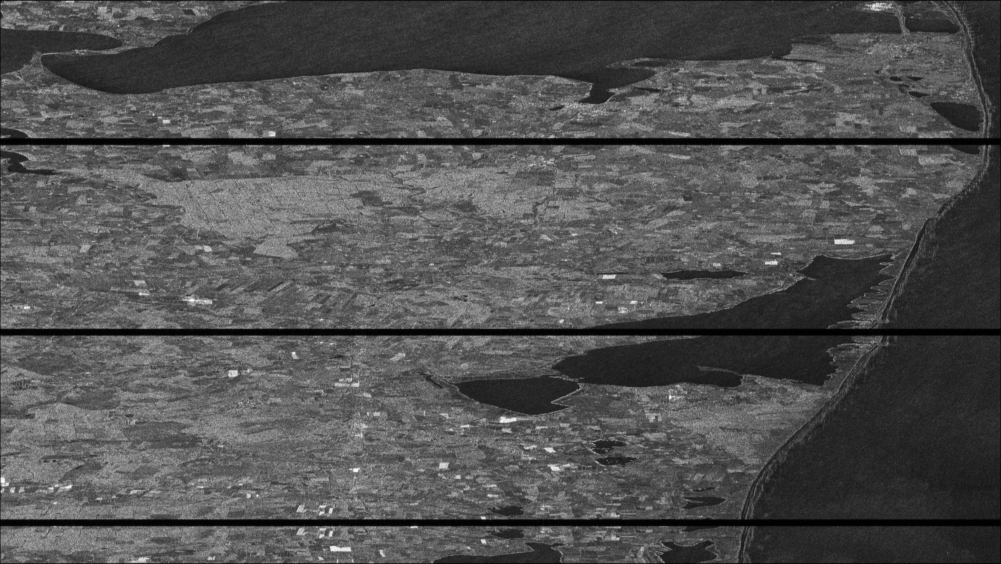

In [14]:
overmaster_path = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
result_folder = "/home/data/eigil/results/coherence6"
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40

#master_view = [2000:6000,1000:9000]
master_view = [6500:11000,2000:10000]

polarization_array = ["VV"]

master = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"
tiff, meta, calibration = Load.slc_paths(master, polarization_array[1], 3)
VV = Load.slc_data(tiff, master_view);

SlcUtil.show_img(VV)

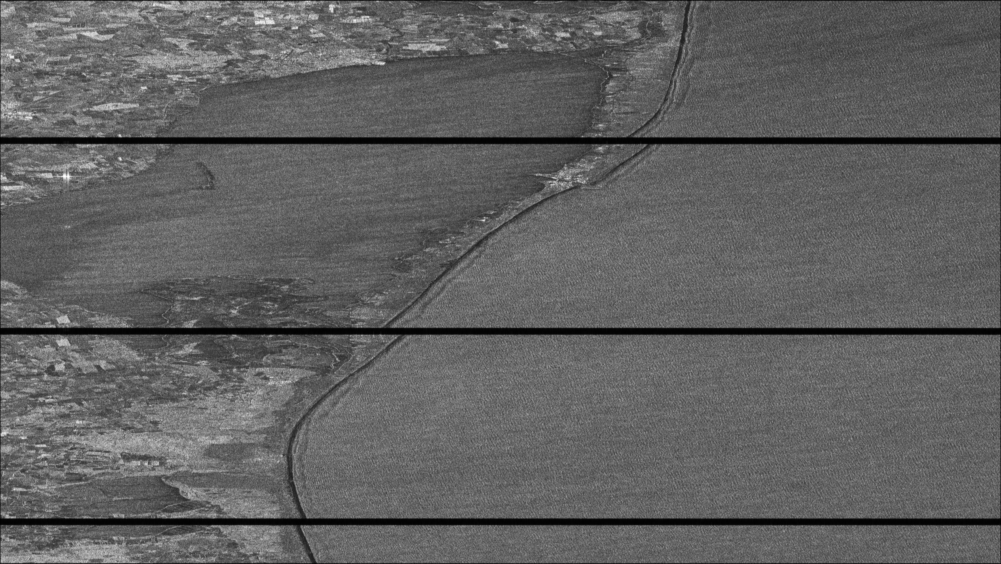

In [29]:
master_view = [2000:6000,1000:9000]
slave = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"
tiff, meta, calibration = Load.slc_paths(slave, polarization_array[1], 3)
VV = Load.slc_data(tiff, master_view);
#VV = Load.slc_data(master_data_path, master_view);

SlcUtil.show_img(VV)

In [28]:
directory = "/home/data/eigil/frame407_406"
all_files = all_SAFE_files(directory)
sorted_files = joinpath.(directory, sort_satellite_type(all_files, "both"))
sorted_files = sorted_files[17:end]
for i in range(2, 3)
    println(sorted_files[i-1])
end

/home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE
/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE


┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[28]:5
└ @ Core ./In[28]:5


In [47]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
#master_view = [2000:6000,1000:9000]
master_view = [6500:11000,2000:10000]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/home/data/eigil/results/coherence6"
save_string = ["coherence", "intensity", "auxillary"]

directory = "/home/data/eigil/frame407_406"
all_files = all_SAFE_files(directory)
sorted_files = joinpath.(directory, sort_satellite_type(all_files, "both"))
sorted_files = sorted_files[17:end]

ID = 0
for i in range(2, stop=length(sorted_files))
    idx = [i-1, i]
    product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
    ID = generate_id(product_folders, "VV")
    
    # EFTER INDEX 16 (DVS 17 og frem, B_20170607_978F) så skal man 
    # skifte view i hver iteration for at få master view der passer
    if string(ID["coherence_id"])[1:2] == "AB"
        println("AB")
        master_view = [2000:6000,1000:9000]
    elseif string(ID["coherence_id"])[1:2] == "BA"
        println("BA")
        master_view = [6500:11000,2000:10000]
    end

    println("Processing:")
    println("Master: $(product_folders[1])")
    println("Slave: $(product_folders[2])")
    tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
    tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)
    
    println("loading POD")
    meta_paths = [meta_m, meta_s]
    meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
    pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
    precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)];
    # load DEM    
    println("loading DEM")
    footprint = SlcUtil.footprint(meta[1], master_view)
    latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
    dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);
    
    println("Coregistering slave")
    slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)
    
    println("Mosaicking")
    slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
    flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);
    
    println("Load master")
    master_data = Load.slc_data(tiff_m, master_view);
    master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);
    
    println("Computing complex coherence")
    complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                        slave_data, flat, kernel, mosaic_view);

    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

BAProcessing:
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data
ABProcessing:
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170619T053944_20170619T054011_006115_00ABDC_75C8.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data
BAProcessing:
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170619T053944_20170619T054011_006115_00ABDC_75C8.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170625T054034_20170625T0541

In [45]:
navn = "BA_VV_M20170309_A0F2_S20170321_8439_12d_coherence.jld"
if string(navn[1:2]) == "AB"
    print("AB")
elseif string(navn[1:2]) == "BA"
    print("BA")
end

BA

In [42]:
navn[1:2]

"AB"

In [ ]:
result_folder = "/home/data/eigil/Uploads"
save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))

In [84]:
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                    for i in 1:length(product_folders)];

In [85]:
# load DEM
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

In [86]:
slave_data,flat,lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

(Complex{Float64}[-0.0 + 0.0im -0.0 + 0.0im … 0.0 - 0.0im 0.0 - 0.0im; -0.08552652797173321 + 11.51344542251527im -38.93135829357113 + 8.089903609046159im … 45.06038664285959 + 8.15765384357734im 40.88631757105155 - 8.164595247621316im; … ; 1.7532265527855415 + 109.14892138296241im -31.542850885558195 + 60.387928595892234im … 1.2876907026770406 + 1.4756958857438234im 16.731187075339015 + 10.089396483334097im; 12.232081688458274 - 118.81113311884755im 84.6030465438318 - 116.02051717039018im … -6.922649527901692 - 14.46132647399296im -17.00705921650696 - 2.9536639587374367im], Complex{Float64}[-0.7315935313583037 + 0.681741083458146im -0.7619459551764715 + 0.6476406112885561im … -0.06254736073305624 - 0.9980419969446821im -0.020875697689627364 - 0.9997820788781779im; -0.7281748788691883 + 0.6853913814630608im -0.7587518090469321 + 0.6513798371672306im … -0.06964848256323758 - 0.9975715958649978im -0.027990273694278197 - 0.9996081955338899im; … ; 0.610819719627358 + 0.791769707752422im 0.

In [87]:
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

In [88]:
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

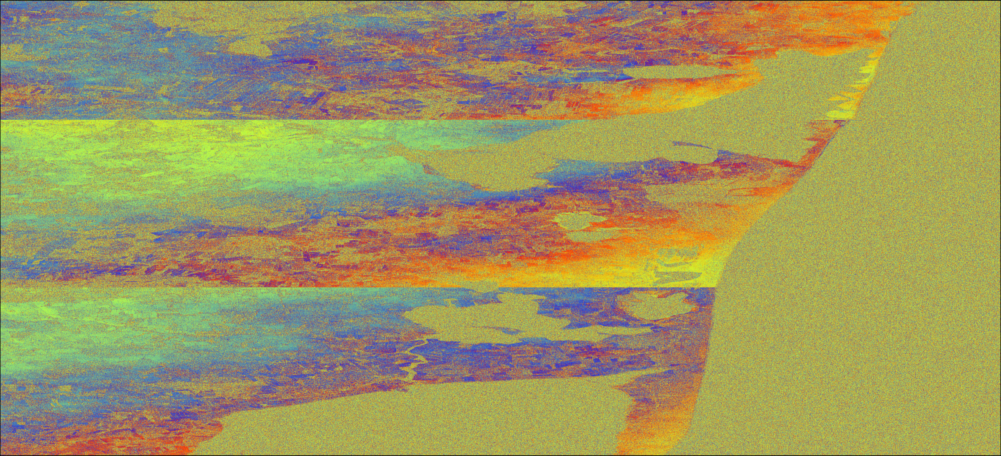

In [89]:
 phase_img = SlcUtil.plot_phase((master_data .* conj.(slave_data).*flat))

In [90]:
kernel = ones(4,14)
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                        slave_data, flat, kernel, mosaic_view);


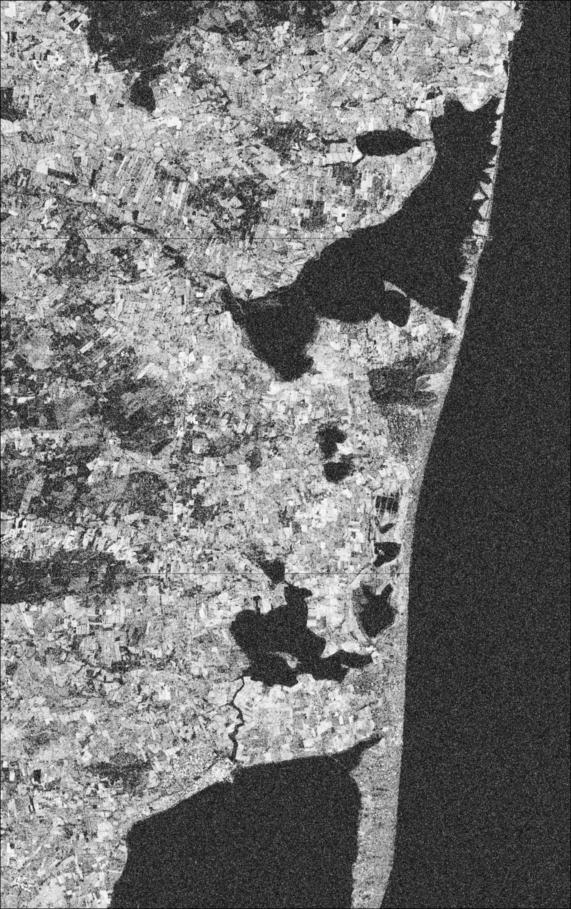

In [92]:
coherence_img = Gray.(abs.(complex_coherence[1:2:end,1:7:end]))

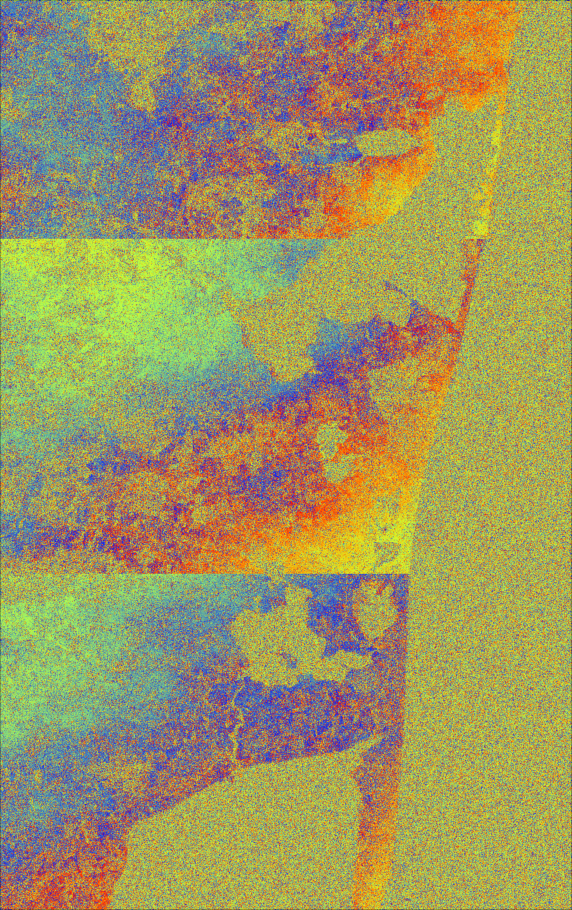

In [95]:
 phase_img = SlcUtil.plot_phase((master_data .* conj.(slave_data).*flat)[1:stride_line:end,1:stride_sample:end])

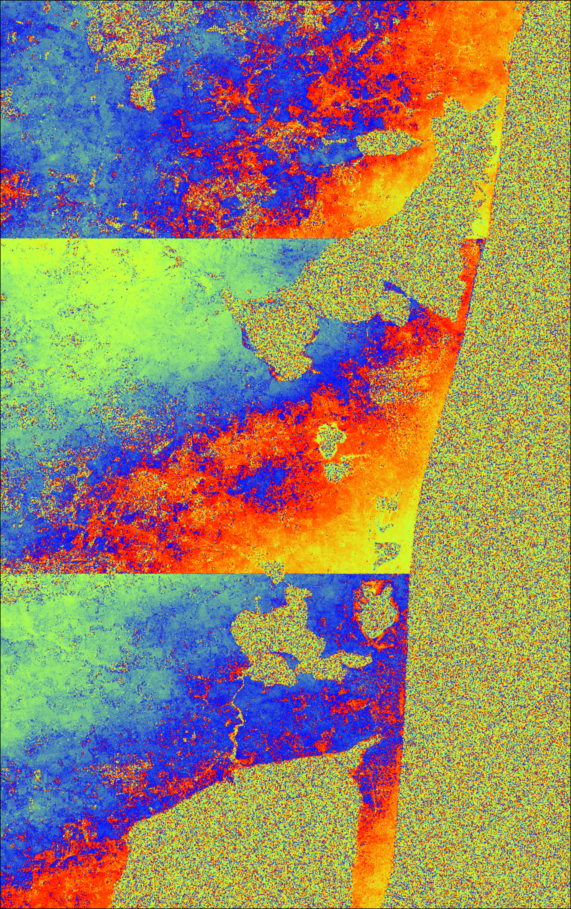

In [97]:
# make stride
stride_line = floor(Int,size(kernel)[1]/2)
stride_sample = floor(Int,size(kernel)[2]/2)
 SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

In [5]:
directory = "/home/data/eigil/results/coherence12"
files = readdir(directory)
index = [split(split(file, ".")[1], "_")[end] == "coherence" for file in files]
files = files[index]
index = [split(file, "_")[end-1] == "12d" for file in files]
files = files[index]
println(size(files))
date_string = [split(file, "_")[3][2:end] for file in files]
files = joinpath.(directory, files[sortperm(Date.(string.(date_string), "yyyymmdd"))])

#files = joinpath.(directory, files[sortperm(extract_datetime.(files, index=3))])

(27,)


27-element Array{String,1}:
 "/home/data/eigil/results/coherence12/BB_VV_M20170303_420F_S20170315_7EE9_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/AA_VV_M20170309_A0F2_S20170321_8439_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/BB_VV_M20170315_7EE9_S20170327_3CC1_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/AA_VV_M20170321_8439_S20170402_080F_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/BB_VV_M20170327_3CC1_S20170408_AEEF_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/AA_VV_M20170402_080F_S20170414_57BD_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/BB_VV_M20170408_AEEF_S20170420_3820_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/AA_VV_M20170414_57BD_S20170426_FE90_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/BB_VV_M20170420_3820_S20170502_AB1F_12d_coherence.jld"
 "/home/data/eigil/results/coherence12/AA_VV_M20170426_FE90_S20170508_75D9_12d_coherence.jld"
 "/home/data/eigil/results/coher

In [133]:
coherence = JLD.load(files[3], "data")[:, end:-1:1]
img = SlcUtil.plot_phase(coherence)
file_name = split(split(files[3], "/")[end], ".")[1]
img_path = joinpath(directory, file_name*".jpg")
FileIO.save(img_path, img);

In [6]:
#coherence_stack = [JLD.load.(file, "data")[:, end:-1:1] for file in files];
#phase_img_stack = [SlcUtil.plot_phase.(img) for img in coherence_stack];
img = 0
for i in range(1, stop=length(files))
    coherence = JLD.load(files[i], "data")[:, end:-1:1]
    if any(isnan,coherence)
        println(i)
    else
        #println(i)
        #coherence = coherence[:, 1:end-50]
        img = SlcUtil.plot_phase(coherence)
        file_name = split(split(files[i], "/")[end], ".")[1]
        img_path = joinpath(directory, file_name*".jpg")
        FileIO.save(img_path, img);
    end
end

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1273


In [136]:
real_part = replace.(real.(coherence), NaN=>0.)
img = SlcUtil.plot_phase(coherence)
file_name = split(split(files[i], "/")[end], ".")[1]
img_path = joinpath(directory, file_name*".jpg")
FileIO.save(img_path, img);

true

In [153]:
coherence = JLD.load("/home/data/eigil/results/coherence6/AB_VV_M20170309_A0F2_S20170315_7EE9_6d_coherence.jld", "data")[:, end:-1:1];
#phase_img = SlcUtil.plot_phase(coherence[:, 1:end-50])
any(isnan, coherence[:, 1:end-50])

false

In [12]:
images_AB = readdir("/home/data/eigil/results/coherence6/images_AB")
index = [split(img, ".")[end] == "jpg" for img in images_AB]
images_AB = images_AB[index]

14-element Array{String,1}:
 "AB_VV_M20170309_A0F2_S20170315_7EE9_6d_coherence.jpg"
 "AB_VV_M20170321_8439_S20170327_3CC1_6d_coherence.jpg"
 "AB_VV_M20170402_080F_S20170408_AEEF_6d_coherence.jpg"
 "AB_VV_M20170414_57BD_S20170420_3820_6d_coherence.jpg"
 "AB_VV_M20170426_FE90_S20170502_AB1F_6d_coherence.jpg"
 "AB_VV_M20170508_75D9_S20170514_333D_6d_coherence.jpg"
 "AB_VV_M20170520_C797_S20170526_31A1_6d_coherence.jpg"
 "AB_VV_M20170601_6FCF_S20170607_978F_6d_coherence.jpg"
 "AB_VV_M20170613_641A_S20170619_75C8_6d_coherence.jpg"
 "AB_VV_M20170625_A750_S20170701_787A_6d_coherence.jpg"
 "AB_VV_M20170719_353A_S20170725_9161_6d_coherence.jpg"
 "AB_VV_M20170731_1BC3_S20170806_BED3_6d_coherence.jpg"
 "AB_VV_M20170812_677B_S20170818_D799_6d_coherence.jpg"
 "AB_VV_M20170824_6C2D_S20170830_1DA1_6d_coherence.jpg"

14-element Array{Array{RGB{FixedPointNumbers.Normed{UInt8,8}},2},1}:
 [RGB{N0f8}(0.11,0.098,0.925) RGB{N0f8}(0.706,0.969,0.314) … RGB{N0f8}(0.953,0.522,0.039) RGB{N0f8}(0.945,0.573,0.0); RGB{N0f8}(0.514,0.918,0.388) RGB{N0f8}(0.396,0.655,0.651) … RGB{N0f8}(0.973,0.573,0.039) RGB{N0f8}(0.996,0.537,0.031); … ; RGB{N0f8}(0.898,0.882,0.118) RGB{N0f8}(0.62,0.945,0.388) … RGB{N0f8}(0.941,0.816,0.098) RGB{N0f8}(0.937,0.753,0.055); RGB{N0f8}(0.922,0.839,0.106) RGB{N0f8}(0.09,0.169,0.855) … RGB{N0f8}(0.871,0.875,0.098) RGB{N0f8}(0.898,0.831,0.078)]
 [RGB{N0f8}(0.569,0.976,0.369) RGB{N0f8}(0.608,0.875,0.447) … RGB{N0f8}(0.212,0.396,0.804) RGB{N0f8}(0.235,0.427,0.8); RGB{N0f8}(0.667,0.957,0.373) RGB{N0f8}(0.227,0.325,0.82) … RGB{N0f8}(0.145,0.31,0.784) RGB{N0f8}(0.204,0.373,0.816); … ; RGB{N0f8}(0.98,0.118,0.0) RGB{N0f8}(0.067,0.125,0.969) … RGB{N0f8}(1.0,0.467,0.051) RGB{N0f8}(0.941,0.498,0.0); RGB{N0f8}(1.0,0.357,0.004) RGB{N0f8}(0.988,0.322,0.0) … RGB{N0f8}(0.949,0.514,0.0) RGB{N0f8}(0.98,0.584,0.067)]             
 [RGB{N0f8}(0.937,0.769,0.075) RGB{N0f8}(0.757,1.0,0.184) … RGB{N0f8}(0.961,0.765,0.086) RGB{N0f8}(0.941,0.757,0.075); RGB{N0f8}(0.42,0.694,0.592) RGB{N0f8}(0.835,0.969,0.184) … RGB{N0f8}(0.929,0.765,0.059) RGB{N0f8}(0.925,0.773,0.063); … ; RGB{N0f8}(0.918,0.871,0.157) RGB{N0f8}(0.043,0.051,0.922) … RGB{N0f8}(0.973,0.624,0.051) RGB{N0f8}(0.965,0.604,0.035); RGB{N0f8}(0.741,1.0,0.231) RGB{N0f8}(0.827,0.894,0.102) … RGB{N0f8}(0.969,0.616,0.035) RGB{N0f8}(0.965,0.592,0.02)] 
 [RGB{N0f8}(0.169,0.239,0.875) RGB{N0f8}(0.906,0.839,0.086) … RGB{N0f8}(0.671,1.0,0.282) RGB{N0f8}(0.957,0.729,0.055); RGB{N0f8}(0.914,0.843,0.114) RGB{N0f8}(0.918,0.851,0.051) … RGB{N0f8}(0.624,0.906,0.482) RGB{N0f8}(0.686,0.965,0.314); … ; RGB{N0f8}(0.596,0.941,0.361) RGB{N0f8}(0.929,0.761,0.114) … RGB{N0f8}(0.682,0.996,0.318) RGB{N0f8}(0.698,1.0,0.31); RGB{N0f8}(1.0,0.635,0.078) RGB{N0f8}(1.0,0.196,0.075) … RGB{N0f8}(0.722,1.0,0.278) RGB{N0f8}(0.729,1.0,0.275)]        
 [RGB{N0f8}(0.973,0.4,0.0) RGB{N0f8}(0.047,0.094,0.973) … RGB{N0f8}(0.031,0.031,1.0) RGB{N0f8}(0.0,0.02,1.0); RGB{N0f8}(0.839,0.973,0.184) RGB{N0f8}(0.769,0.988,0.216) … RGB{N0f8}(0.055,0.129,0.906) RGB{N0f8}(0.996,0.004,0.016); … ; RGB{N0f8}(0.855,0.925,0.157) RGB{N0f8}(0.918,0.847,0.11) … RGB{N0f8}(0.906,0.675,0.039) RGB{N0f8}(0.965,0.737,0.075); RGB{N0f8}(0.678,0.98,0.329) RGB{N0f8}(0.671,0.976,0.341) … RGB{N0f8}(0.976,0.478,0.035) RGB{N0f8}(0.973,0.647,0.035)]        
 [RGB{N0f8}(0.733,1.0,0.235) RGB{N0f8}(0.973,0.525,0.008) … RGB{N0f8}(0.569,0.902,0.404) RGB{N0f8}(1.0,0.333,0.035); RGB{N0f8}(0.647,0.969,0.333) RGB{N0f8}(0.659,0.992,0.353) … RGB{N0f8}(0.478,0.82,0.541) RGB{N0f8}(1.0,0.2,0.004); … ; RGB{N0f8}(1.0,0.149,0.016) RGB{N0f8}(0.659,0.933,0.412) … RGB{N0f8}(0.502,0.741,0.569) RGB{N0f8}(0.169,0.255,0.835); RGB{N0f8}(0.157,0.22,0.941) RGB{N0f8}(0.282,0.565,0.651) … RGB{N0f8}(0.333,0.549,0.631) RGB{N0f8}(0.106,0.255,0.886)]       
 [RGB{N0f8}(0.322,0.553,0.678) RGB{N0f8}(0.443,0.745,0.667) … RGB{N0f8}(0.675,1.0,0.322) RGB{N0f8}(0.663,0.965,0.353); RGB{N0f8}(0.212,0.435,0.753) RGB{N0f8}(0.137,0.247,0.776) … RGB{N0f8}(0.808,1.0,0.161) RGB{N0f8}(0.757,0.992,0.239); … ; RGB{N0f8}(0.318,0.612,0.631) RGB{N0f8}(0.714,0.988,0.365) … RGB{N0f8}(1.0,0.663,0.055) RGB{N0f8}(0.945,0.647,0.016); RGB{N0f8}(0.706,1.0,0.255) RGB{N0f8}(1.0,0.286,0.031) … RGB{N0f8}(0.976,0.525,0.059) RGB{N0f8}(0.949,0.541,0.02)]      
 [RGB{N0f8}(0.973,0.259,0.0) RGB{N0f8}(0.031,0.067,0.957) … RGB{N0f8}(0.11,0.114,0.953) RGB{N0f8}(0.322,0.506,0.71); RGB{N0f8}(0.2,0.31,0.843) RGB{N0f8}(0.114,0.239,0.91) … RGB{N0f8}(0.82,0.906,0.031) RGB{N0f8}(0.467,0.91,0.463); … ; RGB{N0f8}(1.0,0.114,0.0) RGB{N0f8}(0.976,0.624,0.075) … RGB{N0f8}(0.875,0.933,0.129) RGB{N0f8}(0.89,0.824,0.071); RGB{N0f8}(1.0,0.196,0.0) RGB{N0f8}(0.976,0.627,0.055) … RGB{N0f8}(0.843,0.933,0.133) RGB{N0f8}(0.392,0.671,0.6)]                
 [RGB{N0f8}(0.369,0.659,0.569) RGB{N0f8}(0.271,0.49,0.784) … RGB{N0f8}(0.612,0.98,0.357) RGB{N0f8}(0.851,0.965,0.11
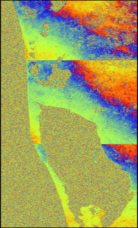
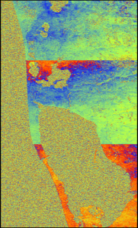
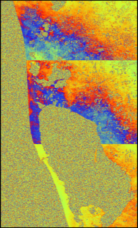
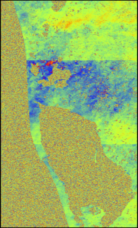
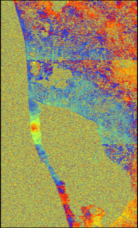
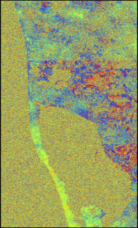
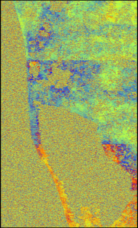
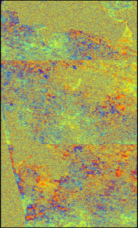
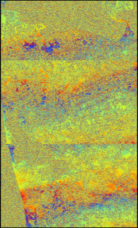
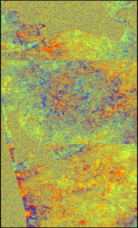
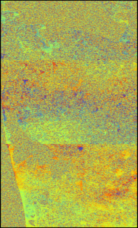
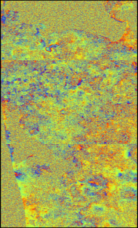
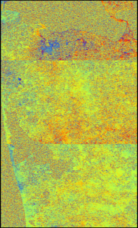
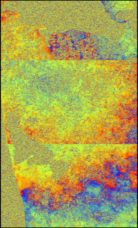

In [14]:
img_stack = Array
for i in range(7)
    
end
img_stack = [load("/home/data/eigil/results/coherence6/images_AB/"*img) for img in images_AB]

DimensionMismatch: DimensionMismatch("new dimensions (1816, 1090, 7) must be consistent with array size 7")

In [21]:
size(img_stack[1])

(1816, 1090)

7-element Array{Array{RGB{FixedPointNumbers.Normed{UInt8,8}},2},1}:
 [RGB{N0f8}(0.11,0.098,0.925) RGB{N0f8}(0.706,0.969,0.314) … RGB{N0f8}(0.953,0.522,0.039) RGB{N0f8}(0.945,0.573,0.0); RGB{N0f8}(0.514,0.918,0.388) RGB{N0f8}(0.396,0.655,0.651) … RGB{N0f8}(0.973,0.573,0.039) RGB{N0f8}(0.996,0.537,0.031); … ; RGB{N0f8}(0.898,0.882,0.118) RGB{N0f8}(0.62,0.945,0.388) … RGB{N0f8}(0.941,0.816,0.098) RGB{N0f8}(0.937,0.753,0.055); RGB{N0f8}(0.922,0.839,0.106) RGB{N0f8}(0.09,0.169,0.855) … RGB{N0f8}(0.871,0.875,0.098) RGB{N0f8}(0.898,0.831,0.078)]
 [RGB{N0f8}(0.569,0.976,0.369) RGB{N0f8}(0.608,0.875,0.447) … RGB{N0f8}(0.212,0.396,0.804) RGB{N0f8}(0.235,0.427,0.8); RGB{N0f8}(0.667,0.957,0.373) RGB{N0f8}(0.227,0.325,0.82) … RGB{N0f8}(0.145,0.31,0.784) RGB{N0f8}(0.204,0.373,0.816); … ; RGB{N0f8}(0.98,0.118,0.0) RGB{N0f8}(0.067,0.125,0.969) … RGB{N0f8}(1.0,0.467,0.051) RGB{N0f8}(0.941,0.498,0.0); RGB{N0f8}(1.0,0.357,0.004) RGB{N0f8}(0.988,0.322,0.0) … RGB{N0f8}(0.949,0.514,0.0) RGB{N0f8}(0.98,0.584,0.067)]             
 [RGB{N0f8}(0.937,0.769,0.075) RGB{N0f8}(0.757,1.0,0.184) … RGB{N0f8}(0.961,0.765,0.086) RGB{N0f8}(0.941,0.757,0.075); RGB{N0f8}(0.42,0.694,0.592) RGB{N0f8}(0.835,0.969,0.184) … RGB{N0f8}(0.929,0.765,0.059) RGB{N0f8}(0.925,0.773,0.063); … ; RGB{N0f8}(0.918,0.871,0.157) RGB{N0f8}(0.043,0.051,0.922) … RGB{N0f8}(0.973,0.624,0.051) RGB{N0f8}(0.965,0.604,0.035); RGB{N0f8}(0.741,1.0,0.231) RGB{N0f8}(0.827,0.894,0.102) … RGB{N0f8}(0.969,0.616,0.035) RGB{N0f8}(0.965,0.592,0.02)] 
 [RGB{N0f8}(0.169,0.239,0.875) RGB{N0f8}(0.906,0.839,0.086) … RGB{N0f8}(0.671,1.0,0.282) RGB{N0f8}(0.957,0.729,0.055); RGB{N0f8}(0.914,0.843,0.114) RGB{N0f8}(0.918,0.851,0.051) … RGB{N0f8}(0.624,0.906,0.482) RGB{N0f8}(0.686,0.965,0.314); … ; RGB{N0f8}(0.596,0.941,0.361) RGB{N0f8}(0.929,0.761,0.114) … RGB{N0f8}(0.682,0.996,0.318) RGB{N0f8}(0.698,1.0,0.31); RGB{N0f8}(1.0,0.635,0.078) RGB{N0f8}(1.0,0.196,0.075) … RGB{N0f8}(0.722,1.0,0.278) RGB{N0f8}(0.729,1.0,0.275)]        
 [RGB{N0f8}(0.973,0.4,0.0) RGB{N0f8}(0.047,0.094,0.973) … RGB{N0f8}(0.031,0.031,1.0) RGB{N0f8}(0.0,0.02,1.0); RGB{N0f8}(0.839,0.973,0.184) RGB{N0f8}(0.769,0.988,0.216) … RGB{N0f8}(0.055,0.129,0.906) RGB{N0f8}(0.996,0.004,0.016); … ; RGB{N0f8}(0.855,0.925,0.157) RGB{N0f8}(0.918,0.847,0.11) … RGB{N0f8}(0.906,0.675,0.039) RGB{N0f8}(0.965,0.737,0.075); RGB{N0f8}(0.678,0.98,0.329) RGB{N0f8}(0.671,0.976,0.341) … RGB{N0f8}(0.976,0.478,0.035) RGB{N0f8}(0.973,0.647,0.035)]        
 [RGB{N0f8}(0.733,1.0,0.235) RGB{N0f8}(0.973,0.525,0.008) … RGB{N0f8}(0.569,0.902,0.404) RGB{N0f8}(1.0,0.333,0.035); RGB{N0f8}(0.647,0.969,0.333) RGB{N0f8}(0.659,0.992,0.353) … RGB{N0f8}(0.478,0.82,0.541) RGB{N0f8}(1.0,0.2,0.004); … ; RGB{N0f8}(1.0,0.149,0.016) RGB{N0f8}(0.659,0.933,0.412) … RGB{N0f8}(0.502,0.741,0.569) RGB{N0f8}(0.169,0.255,0.835); RGB{N0f8}(0.157,0.22,0.941) RGB{N0f8}(0.282,0.565,0.651) … RGB{N0f8}(0.333,0.549,0.631) RGB{N0f8}(0.106,0.255,0.886)]       
 [RGB{N0f8}(0.322,0.553,0.678) RGB{N0f8}(0.443,0.745,0.667) … RGB{N0f8}(0.675,1.0,0.322) RGB{N0f8}(0.663,0.965,0.353); RGB{N0f8}(0.212,0.435,0.753) RGB{N0f8}(0.137,0.247,0.776) … RGB{N0f8}(0.808,1.0,0.161) RGB{N0f8}(0.757,0.992,0.239); … ; RGB{N0f8}(0.318,0.612,0.631) RGB{N0f8}(0.714,0.988,0.365) … RGB{N0f8}(1.0,0.663,0.055) RGB{N0f8}(0.945,0.647,0.016); RGB{N0f8}(0.706,1.0,0.255) RGB{N0f8}(1.0,0.286,0.031) … RGB{N0f8}(0.976,0.525,0.059) RGB{N0f8}(0.949,0.541,0.02)]
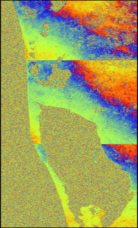
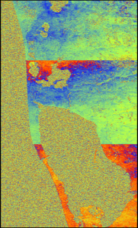
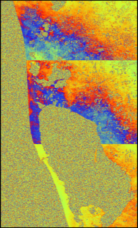
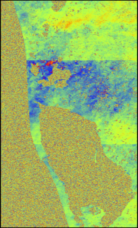
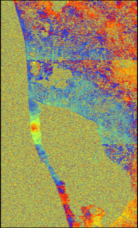
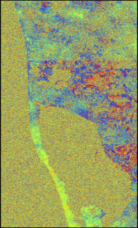
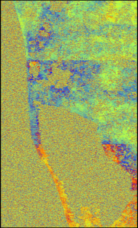

In [22]:
img_stack[1:7]